# Recreating the stellar-mass-complete sample from Hart (2017)

https://data.galaxyzoo.org/

http://www.nsatlas.org/data

In [66]:
%load_ext autoreload
%autoreload 2

[autoreload of sdssCutoutGrab failed: Traceback (most recent call last):
  File "/Users/tlingard/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/Users/tlingard/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/Users/tlingard/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/Users/tlingard/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/tlingard/PhD/gzbuilder_collection/sdss_cutout_grab/sdssCutoutGrab/__init__.py", line 15, in <module>
    import sdssCutoutGrab.sdss_psf as sdss_psf
A

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import numpy as np
import sdssCutoutGrab as scg     
import pandas as pd
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import match_coordinates_sky
from ipywidgets import FloatProgress
from IPython.display import display

In [68]:
HART_GZ2_DATA_LOC = '../../data_files/gz2_hart16.fits.gz'
NSA_LOC = '../../data_files/nsa_v1_0_1.fits'
ROSS_CATALOGUE_LOC = '../../data_files/Hart2017/psi_table.csv'

In [69]:
# Open file containing Ross' debiased statistics
gz2data = fits.open(HART_GZ2_DATA_LOC)

# and the NASA Sloan Atlas for sersic fits etc... (this doesn't have as many headers as I'd expect for some reason)
nsa = fits.open(NSA_LOC)

# and most usefully, Ross' catalog of ra+decs!
columns = 'dr7objid,ra,dec,p_bar,psi_sparcfire,psi_gz2,logMstar'.split(',')
dtype = {
    'names': columns,
    'formats': ('i8', 'float', 'float', 'float', 'float', 'float', 'float')
}
hartPitchAngles = np.loadtxt(ROSS_CATALOGUE_LOC, skiprows=1, delimiter=',', dtype=dtype)

In [70]:
gz2dr7objids = gz2data[1].data['dr7objid']

First, filter for not edge on spirals!

In [71]:
gz2data_keys = [
    'dr7objid', 'ra', 'dec', # to use for cross-referencing
    't01_smooth_or_features_a02_features_or_disk_debiased',
    't02_edgeon_a05_no_debiased',
    't04_spiral_a08_spiral_debiased',
    't11_arms_number_a31_1_flag',
    't11_arms_number_a32_2_flag',
    't11_arms_number_a33_3_flag',
    't11_arms_number_a34_4_flag',
    't11_arms_number_a36_more_than_4_flag',
    't11_arms_number_a37_cant_tell_flag',
]

df_gz2data = pd.DataFrame(gz2data[1].data)[gz2data_keys]
gzRas = df_gz2data['ra']
gzDecs = df_gz2data['dec']
foo2 = df_gz2data['dr7objid']
# p_features * p_not_edge_on * p_spiral >= 0.5
spiral_mask = df_gz2data.eval(
  't01_smooth_or_features_a02_features_or_disk_debiased \
    * t02_edgeon_a05_no_debiased \
    * t04_spiral_a08_spiral_debiased >= 0.5 \
')

In [72]:
# ISDSS is not the same as SDSS objID, so grab that from the query in scg.getFrame?
nsa_keys = [
    'NSAID', 'ISDSS', 'INED', 'RA', 'DEC', 'Z', 'SERSIC_BA', 'SERSIC_PHI', 'PETRO_THETA', 
    'IAUNAME', 'ZDIST', 'RUN', 'CAMCOL', 'FIELD', 'RERUN',
]
nsaRas = nsa[1].data['ra']
nsaDecs = nsa[1].data['dec']

df_nsa = pd.DataFrame(
    {key: nsa[1].data[key].byteswap().newbyteorder() for key in nsa_keys}
)

In [73]:
def getNSpiral(data):
    return data[[
        't11_arms_number_a31_1_flag',
        't11_arms_number_a32_2_flag',
        't11_arms_number_a33_3_flag',
        't11_arms_number_a34_4_flag',
        't11_arms_number_a36_more_than_4_flag',
        't11_arms_number_a37_cant_tell_flag'
    ]]

Coordinate match between Ross & NSA. If the identified separation of a "match" between NSA and Ross' is higher than 0.01 degrees, we ditch the galaxy altogether.

In [74]:
cs = SkyCoord(
  ra=hartPitchAngles['ra']*u.degree,
  dec=hartPitchAngles['dec']*u.degree
)
catalog = SkyCoord(
  ra=df_nsa['RA'].values*u.degree,
  dec=df_nsa['DEC'].values*u.degree
)
jsFull, sep2d, d3d = match_coordinates_sky(cs, catalog)
jsMask = np.logical_not(sep2d > 0.01*u.degree)
js = jsFull[jsMask]
with open('indexMatchNSAtoHart.npy', 'wb') as f:
    np.save(f, js)


dr7objid match between Ross and GZ2

In [75]:
ks = np.fromiter((
    np.where(hartID == gz2dr7objids)[0][0]
    for hartID in hartPitchAngles['dr7objid']
), int, count=hartPitchAngles.shape[0])
with open('indexMatchGZ2toHart.npy', 'wb') as f:
    np.save(f, ks)

And now create a final catalog containing all the info we require!

In [76]:
hartPitchAnglesMatched = hartPitchAngles[jsMask]
hartPitchAnglesMatched.shape

(6114,)

In [77]:
ras = hartPitchAngles['ra'][jsMask]
decs = hartPitchAngles['dec'][jsMask]
zs = df_nsa['Z'][js]
petroThetas = df_nsa['PETRO_THETA'][js]
gz2NSpiralFlags = getNSpiral(df_gz2data).iloc[ks[jsMask]]
dr7objids = hartPitchAngles['dr7objid'][jsMask]
ISDSSs = df_nsa['ISDSS'][js]
INEDs = df_nsa['INED'][js]
NSAIDs = df_nsa['NSAID'][js]
ZDISTs = df_nsa['ZDIST'][js]

Save to a file for future use...

In [78]:
['NSAID', 'ISDSS', 'INED', 'RA', 'DEC', 'Z', 'SERSIC_BA', 'PETRO_THETA', 
    'IAUNAME', 'ZDIST', 'RUN', 'CAMCOL', 'FIELD', 'RERUN',]
dtype = np.dtype([
    ('ra', 'f4'), ('dec', 'f4'), ('z', 'f4'), 
    ('petrotheta', 'f4'), ('gz2NSpiralFlags', '?', 6), 
    ('dr7objid', 'i8'), ('ISDSS', 'i4'), ('INED', 'i4'),
    ('IAUNAME', 'U'), ('NSAID', 'i8'), ('ZDIST', 'f4'), ('SERSIC_BA', 'f4'),
    ('RUN', 'i8'), ('CAMCOL', 'i8'), ('FIELD', 'i8'), ('RERUN', 'i8'),
])
finalTable = np.zeros(hartPitchAnglesMatched.shape[0], dtype=dtype)
finalTable['ra'] = ras
finalTable['dec'] = decs
finalTable['z'] = zs
finalTable['petrotheta'] = petroThetas
finalTable['gz2NSpiralFlags'] = gz2NSpiralFlags
finalTable['dr7objid'] = dr7objids
finalTable['ISDSS'] = ISDSSs
finalTable['INED'] = INEDs
finalTable['NSAID'] = NSAIDs
finalTable['ZDIST'] = ZDISTs
finalTable['RUN'] = df_nsa['RUN'][js]
finalTable['CAMCOL'] = df_nsa['CAMCOL'][js]
finalTable['FIELD'] = df_nsa['FIELD'][js]
finalTable['RERUN'] = df_nsa['RERUN'][js]
finalTable['SERSIC_BA'] = df_nsa['SERSIC_BA'][js]

In [79]:
with open('finalTable.npy', 'wb') as f:
    np.save(f, finalTable)

## Okay, we now have all the data we need to generate the required cutouts! 

But we don't want to inject the full sample as one subject set... We'll mainly prioritise with redshift, but have 40% of each "batch" selected from the remaining galaxies.

In [80]:
# known seed for consistency
np.random.seed(21508479)
sortedByRedshift = np.argsort(finalTable['z'])
zGtZeroMask = finalTable['z'][sortedByRedshift] > 0
# don't know why one thing has z < 0, but I'm gonna ignore it
finalOrderedByRedshift = finalTable[sortedByRedshift[zGtZeroMask]]

In [86]:
with open('original_finalOrderedByRedshift.npy', 'wb') as f:
  np.save(f, finalOrderedByRedshift)

Now create batches of 100 comprised of the 60 lowest redshift and 40 randomly selected from the remaining galaxies, and save the output!

In [15]:
available = np.ones(finalOrderedByRedshift.shape[0], dtype=bool)
foo = np.zeros((62, 100), dtype=int)
for i in range(61):
    low60 = np.where(available)[0][:60]
    available[low60] = False
    rd40 = np.sort(np.random.choice(np.where(available)[0], size=40, replace=False))
    available[rd40] = False
    ss = np.append(
        low60, 
        rd40,
    )
    foo[i] = ss
    with open('subjectSetIndices/subjectSet{}.npy'.format(i), 'wb') as f: 
        np.save(f, ss)

## And now the subject preparation

It makes more sense to perform this in a script, but I'll demonstrate the creation of the zero-th subject set here

In [9]:
import subjectCreator as subC
subC = reload(subC)
setNumber = 2

Want to look at a galaxy? Use this code:

In [17]:
i = 20
getUrl = lambda ra, dec:  "http://skyserver.sdss.org/dr14/en/tools/chart/navi.aspx?ra={ra}&dec={dec}&opt=F".format(
    ra=ra,
    dec=dec
)
print(getUrl(finalOrderedByRedshift[foo[setNumber][i]]['ra'], finalOrderedByRedshift[foo[setNumber][i]]['dec']))
print(finalOrderedByRedshift[foo[setNumber][i]])
with open('finalOrderedByRedshift.npy', 'wb') as f:
    np.save(f, finalTable)

http://skyserver.sdss.org/dr14/en/tools/chart/navi.aspx?ra=151.01560974121094&dec=31.04303550720215&opt=F
(151.01561, 31.043036, 0.02221227, 14.077064, [False, False, False, False, False, False], 587739408380264596, 418403, 76587, '', 413053, 0.02209515, 0.7899778, 4516, 2, 163, 301)


In [19]:
files, success, err, montageFailures = [], [], [], []
for i in range(83, foo[setNumber].shape[0]):
    gal = finalOrderedByRedshift[foo[setNumber][i]]
    try:
        res = subC.pipeline(
            gal,
            outputFolder='subject_set_{}'.format(setNumber),
            subjectName='subject{}'.format(i)
        )
        if res:
            success += [i]
            files += [res]
        else:
            montageFailures += [i]
    except Exception as e:
        print(e, i, foo[setNumber][i])
        err += [i]

INFO: Listing raw frames [montage_wrapper.wrappers]
INFO: Computing optimal header [montage_wrapper.wrappers]
INFO: Projecting raw frames [montage_wrapper.wrappers]
INFO: Determining overlaps [montage_wrapper.wrappers]
INFO: Modeling background [montage_wrapper.wrappers]
INFO: Matching background [montage_wrapper.wrappers]
INFO: Mosaicking frames [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/z2/y1lrc76x3tg_jc0ftm6tshr40000gn/T/montage_mosaic_220.02932739257812+19.06937026977539_x__y07wa [montage_wrapper.wrappers]
Sorting extracted objects by radius from center
🤖 [sdssCutoutGrab Info] writing to subject_set_2/psf_subject83.png
📷  Saving image to subject_set_2/image_subject83.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


buffer is too small for requested array 84 3525
🤖 [sdssCutoutGrab Info] writing to images/3631/4/frame-r-003631-4-0033.fits
🤖 [sdssCutoutGrab Info] writing to images/3631/4/frame-r-003631-4-0032.fits
INFO: Listing raw frames [montage_wrapper.wrappers]
INFO: Computing optimal header [montage_wrapper.wrappers]
INFO: Projecting raw frames [montage_wrapper.wrappers]
INFO: Determining overlaps [montage_wrapper.wrappers]
INFO: Modeling background [montage_wrapper.wrappers]
INFO: Matching background [montage_wrapper.wrappers]
INFO: Mosaicking frames [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/z2/y1lrc76x3tg_jc0ftm6tshr40000gn/T/montage_mosaic_121.4052505493164+6.908231258392334_lbxkdgf6 [montage_wrapper.wrappers]
Sorting extracted objects by radius from center
🤖 [sdssCutoutGrab Info] writing to subject_set_2/psf_subject85.png
📷  Saving image to subject_set_2/image_subject85.png
🤖 [sdssCutoutGrab Info] Making directory images/3462
🤖 [sdssCutoutGrab Info] Making direct

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Sorting extracted objects by radius from center
🤖 [sdssCutoutGrab Info] writing to subject_set_2/psf_subject90.png
📷  Saving image to subject_set_2/image_subject90.png
🤖 [sdssCutoutGrab Info] Making directory images/6004/5
🤖 [sdssCutoutGrab Info] writing to images/6004/5/frame-r-006004-5-0157.fits
🤖 [sdssCutoutGrab Info] writing to images/6004/5/frame-r-006004-5-0156.fits
INFO: Listing raw frames [montage_wrapper.wrappers]
INFO: Computing optimal header [montage_wrapper.wrappers]
INFO: Projecting raw frames [montage_wrapper.wrappers]
INFO: Determining overlaps [montage_wrapper.wrappers]
INFO: Modeling background [montage_wrapper.wrappers]
INFO: Matching background [montage_wrapper.wrappers]
INFO: Mosaicking frames [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/z2/y1lrc76x3tg_jc0ftm6tshr40000gn/T/montage_mosaic_139.1273651123047+13.0991849899292_ci4m0pzu [montage_wrapper.wrappers]
Sorting extracted objects by radius from center
🤖 [sdssCutoutGrab Info] writing to s

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Sorting extracted objects by radius from center
🤖 [sdssCutoutGrab Info] writing to subject_set_2/psf_subject93.png
📷  Saving image to subject_set_2/image_subject93.png
🤖 [sdssCutoutGrab Info] Making directory images/1453
🤖 [sdssCutoutGrab Info] Making directory images/1453/5
🤖 [sdssCutoutGrab Info] writing to images/1453/5/frame-r-001453-5-0071.fits
🤖 [sdssCutoutGrab Info] writing to images/1453/5/frame-r-001453-5-0072.fits
INFO: Listing raw frames [montage_wrapper.wrappers]
INFO: Computing optimal header [montage_wrapper.wrappers]
INFO: Projecting raw frames [montage_wrapper.wrappers]
INFO: Determining overlaps [montage_wrapper.wrappers]
INFO: Modeling background [montage_wrapper.wrappers]
INFO: Matching background [montage_wrapper.wrappers]
INFO: Mosaicking frames [montage_wrapper.wrappers]
INFO: Deleting work directory /var/folders/z2/y1lrc76x3tg_jc0ftm6tshr40000gn/T/montage_mosaic_251.9225616455078+44.905006408691406_mbjslfap [montage_wrapper.wrappers]
Sorting extracted objects by 

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Sorting extracted objects by radius from center
🤖 [sdssCutoutGrab Info] writing to subject_set_2/psf_subject95.png
📷  Saving image to subject_set_2/image_subject95.png
🤖 [sdssCutoutGrab Info] Making directory images/1336/5
🤖 [sdssCutoutGrab Info] writing to images/1336/5/frame-r-001336-5-0093.fits
Sorting extracted objects by radius from center
🤖 [sdssCutoutGrab Info] writing to subject_set_2/psf_subject96.png
📷  Saving image to subject_set_2/image_subject96.png
🤖 [sdssCutoutGrab Info] writing to images/3893/3/frame-r-003893-3-0226.fits
Sorting extracted objects by radius from center
🤖 [sdssCutoutGrab Info] writing to subject_set_2/psf_subject97.png
📷  Saving image to subject_set_2/image_subject97.png
🤖 [sdssCutoutGrab Info] writing to images/5322/5/frame-r-005322-5-0090.fits
Sorting extracted objects by radius from center
🤖 [sdssCutoutGrab Info] writing to subject_set_2/psf_subject98.png
📷  Saving image to subject_set_2/image_subject98.png
🤖 [sdssCutoutGrab Info] writing to images/390

Let's check the output difference data

In [20]:
print(len(files), len(success), len(err), len(montageFailures))

16 16 1 0


In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
from createSubjectsFunctions import stretchArray
import json
from astropy.visualization import AsinhStretch

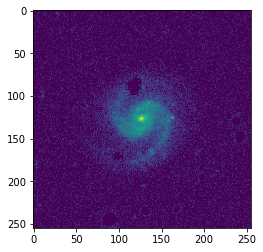

In [22]:
with open('subject_set_{}/difference_subject39.json'.format(setNumber)) as f:
    diffData = json.load(f)
im = np.array(diffData['imageData'])
im2 = AsinhStretch()(im)
plt.imshow(im2)

## Sending the subjects to the zooniverse!

And now to upload the subjects to the zooniverse... God help me

In [11]:
from uploadSubjects import uploadSubjectToSet 
import getpass
import os
import json
import re
from panoptes_client import SubjectSet, Subject, Project, Panoptes

In [25]:
uname = input('Enter your username: ')
pwd = getpass.getpass()

Enter your username: tingard
········


In [6]:
availableIndices = sorted(
    int(re.match(r'image_subject([0-9]+)\.png', f).group(1))
    for f in os.listdir('subject_set_0')
    if re.match(r'image_subject([0-9]+)\.png', f)
)
print(availableIndices)
files = [
    '{0}/image_subject{1}.png,{0}/model_subject{1}.json,{0}/difference_subject{1}.json,{0}/metadata_subject{1}.json'.format(
        'subject_set_{}'.format(setNumber),
        i
    ).split(',')
    for i in availableIndices]
files = [list(map(os.path.abspath, i)) for i in files]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [13]:
Panoptes.connect(
    username=uname,
    password=pwd,
    # endpoint='https://panoptes-staging.zooniverse.org',
    admin=True
)
pId = 5590  # if production else 1820
project = Project.find(pId)
subject_set = SubjectSet()
subject_set.links.project = project
subject_set.display_name = 'SubjectSet{}_17-5-18'.format(setNumber)
subject_set.save()

loc = '.'
subjects = os.listdir(loc + '/subject_set_{}'.format(setNumber))
images, differences, model, metadata = [
    sorted((
        int(re.match(r'{}_subject([0-9]+)\.(?:json|png)$'.format(s), i).group(1))
        for i in subjects
        if re.match(r'{}_subject([0-9]+)\.(?:json|png)$'.format(s), i)
    ))
    for s in ('image', 'difference', 'model', 'metadata')
]
if not images == differences == model == metadata:
    print(
        'Images, differences, model and metadata ' +
        'must all have same length'
    )

# TODO: change subject directory structure to be more efficient
#       (not having 12,000+ files in a folder...)
for fs in files:
    if fs != False:
        print(fs)
        try:
            with open(fs[3]) as metaF:
                metadata = json.load(metaF)
        except IOError:
            metadata = {}
        subject_set = uploadSubjectToSet(
            project, subject_set,
            [[fs[0], fs[2], fs[1]]],  # locations
            [metadata],
        )

['/Users/tlingard/PhD/galaxy-builder/subjectUpload/subject_set_0/image_subject0.png', '/Users/tlingard/PhD/galaxy-builder/subjectUpload/subject_set_0/model_subject0.json', '/Users/tlingard/PhD/galaxy-builder/subjectUpload/subject_set_0/difference_subject0.json', '/Users/tlingard/PhD/galaxy-builder/subjectUpload/subject_set_0/metadata_subject0.json']
['/Users/tlingard/PhD/galaxy-builder/subjectUpload/subject_set_0/image_subject1.png', '/Users/tlingard/PhD/galaxy-builder/subjectUpload/subject_set_0/model_subject1.json', '/Users/tlingard/PhD/galaxy-builder/subjectUpload/subject_set_0/difference_subject1.json', '/Users/tlingard/PhD/galaxy-builder/subjectUpload/subject_set_0/metadata_subject1.json']
['/Users/tlingard/PhD/galaxy-builder/subjectUpload/subject_set_0/image_subject2.png', '/Users/tlingard/PhD/galaxy-builder/subjectUpload/subject_set_0/model_subject2.json', '/Users/tlingard/PhD/galaxy-builder/subjectUpload/subject_set_0/difference_subject2.json', '/Users/tlingard/PhD/galaxy-build

In [ ]:
# subC=reload(subC)
# import json
# for i in range(foo[0].shape[0]):
#     gal = finalOrderedByRedshift[foo[0][i]]
#     metadata = subC.makeMetadata(gal)
#     with open('/Users/tlingard/PhD/galaxy-builder/subjectUpload/subject_set_0/metadata_subject{}.json'.format(i), 'r') as mFile:
#         j = json.load(mFile)
#     print(metadata['ra'] == j['ra'])